# Решающее дерево

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

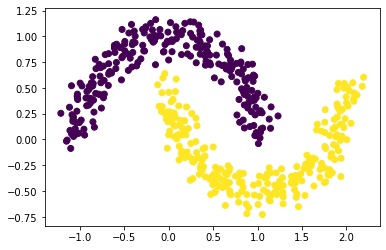

In [12]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_blobs, y_blobs = make_moons(n_samples=500, noise=0.1)
plt.scatter(x_blobs[:,0], x_blobs[:,1], c = y_blobs)


## Задание

Напишите класс дерева, который реализует метод train, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает дерево в виде словаря в каждом случае записывается номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$). Вместо занчения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее.

Необходимо учесть:

1. Возможность строить дерево строго определенной глубины и возможность указать максимальное количество объектов в листовой вершине.
2. Пороги разбиения должны лежать строго по середине между ближайшими обектами.
3. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
4. Количество различных классов объектов в целевой переменной может быть больше двух.


In [0]:
import math

In [0]:
def entropy_func(class_count, spl_group_len):
    return -(class_count*1.0/spl_group_len)*math.log(class_count*1.0/spl_group_len, 2)


def entropy_cal(class_1_count, class_2_count):
    if class_1_count == 0 or class_2_count == 0:
        return 0
    splt_group_len = class_1_count + class_2_count
    return entropy_func(class_1_count, splt_group_len) + entropy_func(class_2_count, splt_group_len)


def entropy_of_split(splitted_group): 
    split_entropy = 0
    spl_group_len = len(splitted_group)
    for uniq_set_val in set(splitted_group):
        sum_uniq_val = sum(splitted_group==uniq_set_val)
        uniq_val_entropy = sum_uniq_val*1.0/spl_group_len * entropy_cal(sum(splitted_group==uniq_set_val), 
                                                                        sum(splitted_group!=uniq_set_val))
        split_entropy += uniq_val_entropy
    return split_entropy, spl_group_len


def get_entropy(y_predict, y_real):
    n = len(y_real)
    entropy_left, len_left = entropy_of_split(y_real[y_predict])
    entropy_right, len_right = entropy_of_split(y_real[~y_predict])
    avg_entropy = len_left*1.0/n * entropy_left + len_right*1.0/n * entropy_right
    return avg_entropy

In [0]:
class Tree:
    def __init__(self, depth=1, max_num_leaf=1):
        self.depth = depth
        self.max_num_leaf = max_num_leaf
    

    def find_best_col_split(self, col, y):
        min_entropy = 10    
        n = len(y)
        for value in set(col):
            y_predict = col < value
            entropy = get_entropy(y_predict, y)
            if entropy <= min_entropy:
                min_entropy = entropy
                cutoff = value
        return min_entropy, cutoff
    

    def find_best_data_split(self, x, y):
        col = None
        min_entropy = 1
        cutoff = None
        for ind, x_col in enumerate(x.T):  # 1 row: {feature_1: columns with values}, 2 row: {...}
            entropy, cur_cutoff = self.find_best_col_split(x_col, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return ind, cur_cutoff, entropy
            elif entropy <= min_entropy:  # check if it's best so far
                min_entropy = entropy
                col = ind
                cutoff = cur_cutoff
        return col, cutoff, min_entropy


    def fit(self, x, y, node={}, current_depth=0):
        if node is None: # tree stops at previous level
            return None
        elif len(y) == 0: # no data in this leaf
            return None
        elif all(item == y[0] for item in y): # all y (classes) are the same in this leaf
            return {'val':y[0]}
        elif current_depth >= self.depth:
            return None
        else:   # Recursive
            column, cutoff, entropy = self.find_best_data_split(x, y)   
            y_left = y[x[:, column] < cutoff]  # left hand side data
            y_right = y[x[:, column] >= cutoff]  # right hand side data
            # node = {'column': iris.feature_names[column], 'index_col':column,
            #         'cutoff':cutoff, 'val': np.round(np.mean(y))}
            node = {'index_col':column, 'cutoff':cutoff, 'val': np.round(np.mean(y))}
            node['left'] = self.fit(x[x[:, column] < cutoff], y_left, {}, current_depth+1)   
            node['right'] = self.fit(x[x[:, column] >= cutoff], y_right, {}, current_depth+1)  
            self.depth += 1   # one level was passed
            self.trees = node  
        return node
    
    def predict(self, x):
        results = np.array([0]*len(x))
        for i, c in enumerate(x):  # for each row in test data 
            results[i] = self._get_prediction(c)  
        return results

    def _get_prediction(self, row):
        cur_layer = self.trees  # get the tree we build in training
        while cur_layer.get('cutoff'):   # if not leaf node
            if row[cur_layer['index_col']] < cur_layer['cutoff']:   # get the direction 
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:   # if leaf node, return value
            return cur_layer.get('val')

In [23]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pprint import pprint

iris = load_iris()

x = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(x,y)
clf = Tree(depth=7)
res = clf.fit(X_train, y_train)

pprint(res)

{'cutoff': 1.0,
 'index_col': 3,
 'left': {'val': 0},
 'right': {'cutoff': 1.7,
           'index_col': 3,
           'left': {'cutoff': 5.0,
                    'index_col': 2,
                    'left': {'val': 1},
                    'right': {'cutoff': 1.6,
                              'index_col': 3,
                              'left': {'val': 2},
                              'right': {'cutoff': 7.2,
                                        'index_col': 0,
                                        'left': {'val': 1},
                                        'right': {'val': 2},
                                        'val': 2.0},
                              'val': 2.0},
                    'val': 1.0},
           'right': {'cutoff': 4.9,
                     'index_col': 2,
                     'left': {'cutoff': 3.2,
                              'index_col': 1,
                              'left': {'val': 2},
                              'right': {'val': 1},
               

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112, 4), (38, 4), (112,), (38,))

In [0]:
clf_predictions = clf.predict(X_test)

In [26]:
accuracy_score(y_test, clf_predictions)

0.9736842105263158

In [33]:
X_train_blobs, X_test_blobs, y_train_blobs, y_test_blobs = train_test_split(x_blobs, y_blobs)
clf_blobs = Tree(depth=5)
blobs_nodes = clf_blobs.fit(X_train_blobs, y_train_blobs)
blobs_pred = clf_blobs.predict(X_test_blobs)
print(f"blobs accuracy = {accuracy_score(y_test_blobs, blobs_pred)}")

blobs accuracy = 1.0


In [34]:
pprint(blobs_nodes)

{'cutoff': -0.040103247278818616,
 'index_col': 1,
 'left': {'cutoff': -0.01599843703549174,
          'index_col': 0,
          'left': {'val': 0},
          'right': {'val': 1},
          'val': 1.0},
 'right': {'cutoff': 1.6649736191319648,
           'index_col': 0,
           'left': {'cutoff': 0.6463861716368935,
                    'index_col': 1,
                    'left': {'cutoff': -0.1244461657354374,
                             'index_col': 0,
                             'left': {'val': 0},
                             'right': {'cutoff': 0.5138013567654576,
                                       'index_col': 0,
                                       'left': {'val': 1},
                                       'right': {'val': 0},
                                       'val': 0.0},
                             'val': 0.0},
                    'right': {'val': 0},
                    'val': 0.0},
           'right': {'val': 1},
           'val': 0.0},
 'val': 1.0}


Постройте решающее дерево с глубиной 1, 2 и 3.

Визуализируйте получившиеся результаты классификатора на плоскости. Для этого воспользуйтесь кодом ниже, чтобы построить поверхность. $t$ - порог разбиения $i$ - номер признака.

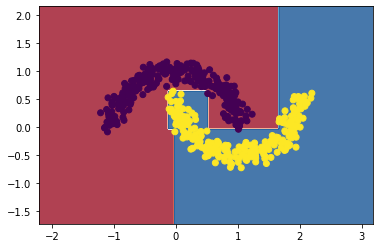

In [35]:
# def tree_clf(x):
#     y_pred = list()  
#     for it in x.transpose():
#         # Алгоритм классификации
#         y_pred.append(np.round(np.random.random())) # Пока дерево классифицирует случайный класс.
#     return np.array(y_pred)


h = .02
x0_min, x0_max = np.min(x_blobs[:,0]) - 1, np.max(x_blobs[:,0]) + 1
x1_min, x1_max = np.min(x_blobs[:,1]) - 1, np.max(x_blobs[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

# Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))
Z = clf_blobs.predict(np.transpose(np.stack((xx0.ravel(),xx1.ravel()))))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x_blobs[:,0], x_blobs[:,1], c = y_blobs)

Постройте дерево максимальной глубины для своих случайных данных.